# Acoustic Regression Model Comparision Code

In [1]:
# import needed libraries
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
import tensorflow as tf
import sklearn
from scipy import signal
from scipy.fft import fftshift
from keras.callbacks import ModelCheckpoint, EarlyStopping
from time import perf_counter
import pickle

### Import & Transform Data

In [2]:
data=pd.read_csv('C:/Users/cldunlap/Box/Nano Energy Lab Shared Folder/Christy/Multimodal Fusion/Direction 3_Multi-Fidelity Learning using Gaussian Process Regression/realigned_w_img_sound_and_hf.csv', sep=',')
data=np.asarray(data)
hf=data[:,2]
sound=data[:,3]
dx_sound=0.00048828
sr=int(1/dx_sound)
time_og=data[:,1]

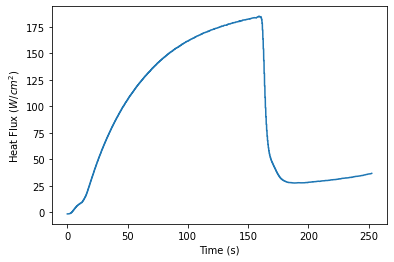

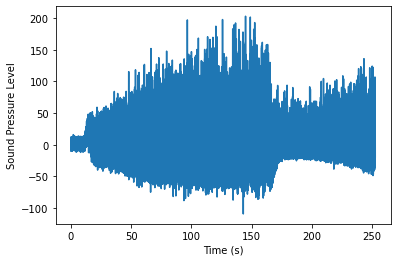

In [3]:
plt.plot(time_og,hf)
plt.xlabel('Time (s)')
plt.ylabel(r'Heat Flux $(W/cm^2)$')
plt.show()

plt.plot(time_og, sound)
plt.xlabel('Time (s)')
plt.ylabel('Sound Pressure Level')
plt.show()

In [4]:
def create_data(x, y,t, sl, stride):
    amt=int((len(x)-sl)/stride)
    xnew=np.array([[0. for i in range(sl)]for j in range(amt)])
    ynew=np.array([0. for i in range(amt)])
    time=np.array([0. for i in range(amt)])
    for i in range(amt):
        xnew[i]=x[i*stride:(i*stride)+sl]
        ynew[i]=y[(i*(stride))+sl-1]
        time[i]=t[(i*stride)+sl-1]
    return xnew, ynew, time

In [5]:
sound_clips, hf, time=create_data(sound, hf,time_og, 4000,100)

In [6]:
indicies=np.array([i for i in range(len(time))])


In [7]:
# split data into testing and training
sound_train,sound_test,hf_train,hf_test,time_train,time_test,index_train,index_test=train_test_split(sound_clips,hf,time,indicies,test_size=0.2,shuffle=True,random_state=43 )

In [8]:
np.save('index_train.npy',index_train)
np.save('index_test.npy',index_test)

In [9]:
# Define Error metrics
def mape(pred, true):
    N=len(pred)
    summation=np.sum(abs(np.divide(pred-true, true)))
    print()
    y=(1/N)*summation
    return y

In [10]:
# Find time of chf
chf_time=time[np.where(hf==np.amax(hf))[-1][-1]]
print(chf_time)

159.276855


## FFT Feature Transformation

In [11]:
def compute_fft(signal, dx):
    N=len(signal) # subtract mean 
    time=np.array([i*dx for i in range(N)])
    y_f=np.fft.fft(signal-np.mean(signal))
    x_f=np.linspace(0.0, 1.0/(2.0*dx), N//2)
    y_f=2.0/N *np.abs(y_f[:N//2])
    return y_f

In [12]:
fft_train=np.array([compute_fft(sound_train[0],dx_sound)])
for i in range(len(sound_train)-1):
    fft_train=np.append(fft_train,np.array([compute_fft(sound_train[i+1],dx_sound)]),axis=0)
    
fft_test=np.array([compute_fft(sound_test[0],dx_sound)])
for i in range(len(sound_test)-1):
    fft_test=np.append(fft_test,np.array([compute_fft(sound_test[i+1],dx_sound)]),axis=0)

### MLP Model

In [13]:
inputs=tf.keras.layers.Input(shape=(fft_train.shape[1]))
x=tf.keras.layers.Dense(100, activation='relu')(inputs)
x=tf.keras.layers.Dense(75, activation='relu')(x)
x=tf.keras.layers.Dense(50, activation='relu')(x)
x=tf.keras.layers.Dense(25, activation='relu')(x)
x=tf.keras.layers.Dense(10, activation='relu')(x)
out=tf.keras.layers.Dense(1)(x)
model=tf.keras.models.Model(inputs=inputs, outputs=out)

model.compile(optimizer='SGD', loss='mae')

filepath='./models_final/fft-mlp-weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5'

checkpoint=ModelCheckpoint(filepath,monitor='val_loss',verbose=1,save_best_only=True,mode='min')
early_stop=EarlyStopping(monitor='val_loss',patience=3,verbose=3)

callbacks_list=[checkpoint,early_stop]

In [14]:
xval=np.amax(fft_train)
yval=np.amax(hf_train)
start=perf_counter()
model.fit(fft_train/xval,hf_train/yval, epochs=100, validation_split=.1,callbacks=callbacks_list)
stop=perf_counter()
print('Time: ', stop-start)
print('FFT-MLP-R2 Score:',sklearn.metrics.r2_score(hf_test,model.predict(fft_test/xval)*yval))
print('FFT-MLP-MAPE: ',mape(np.reshape(model.predict(fft_test/xval)*yval,-1),hf_test))

Epoch 1/100
 61/116 [==============>...............] - ETA: 0s - loss: 0.2921 
Epoch 1: val_loss improved from inf to 0.07206, saving model to ./models_final\fft-mlp-weights-improvement-01-0.07.hdf5
116/116 [==============================] - 0s 2ms/step - loss: 0.2259 - val_loss: 0.0721
Epoch 2/100
 56/116 [=============>................] - ETA: 0s - loss: 0.0641
Epoch 2: val_loss improved from 0.07206 to 0.05119, saving model to ./models_final\fft-mlp-weights-improvement-02-0.05.hdf5
116/116 [==============================] - 0s 1ms/step - loss: 0.0596 - val_loss: 0.0512
Epoch 3/100
116/116 [==============================] - ETA: 0s - loss: 0.0475
Epoch 3: val_loss improved from 0.05119 to 0.03442, saving model to ./models_final\fft-mlp-weights-improvement-03-0.03.hdf5
116/116 [==============================] - 0s 1ms/step - loss: 0.0475 - val_loss: 0.0344
Epoch 4/100
 62/116 [===============>..............] - ETA: 0s - loss: 0.0436
Epoch 4: val_loss improved from 0.03442 to 0.03167, 

33/33 [==============================] - 0s 562us/step


Text(0.5, 1.0, 'FFT-MLP Model')

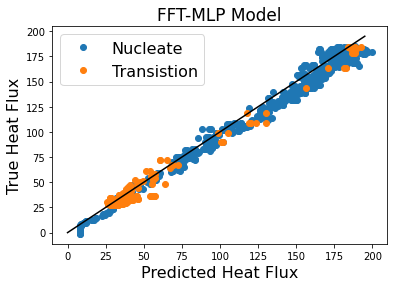

In [15]:
plt.plot(model.predict(fft_test/xval)[time_test<chf_time]*yval,hf_test[time_test<chf_time],'o', label='Nucleate')
plt.plot(model.predict(fft_test/xval)[time_test>=chf_time]*yval,hf_test[time_test>=chf_time],'o', label='Transistion')
plt.plot([0,195],[0,195], c='black')
plt.legend(fontsize=16)
plt.ylabel('True Heat Flux', fontsize=16)
plt.xlabel('Predicted Heat Flux', fontsize=16)
plt.title('FFT-MLP Model', fontsize=17)

### RFR Model

In [16]:
start=perf_counter()
rfr=RandomForestRegressor(max_depth=100, random_state=1)
rfr.fit(fft_train,hf_train)
stop=perf_counter()
print('Time: ',stop-start)
print('FFT-RFR-R2 Score:',rfr.score(fft_test,hf_test))
print('FFT-RFR-MAPE: ', mape(rfr.predict(fft_test),hf_test))

Time:  360.1139771
FFT-RFR-R2 Score: 0.9936133078016894

FFT-RFR-MAPE:  0.0531782348247985


Text(0.5, 1.0, 'FFT-RFR Model')

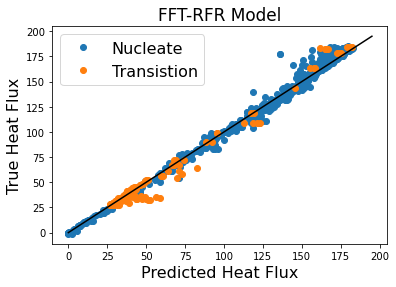

In [17]:
plt.plot(rfr.predict(fft_test)[time_test<chf_time],hf_test[time_test<chf_time],'o', label='Nucleate')
plt.plot(rfr.predict(fft_test)[time_test>=chf_time],hf_test[time_test>=chf_time],'o', label='Transistion')
plt.plot([0,195],[0,195], c='black')
plt.legend(fontsize=16)
plt.ylabel('True Heat Flux', fontsize=16)
plt.xlabel('Predicted Heat Flux', fontsize=16)
plt.title('FFT-RFR Model', fontsize=17)

In [18]:
fft_rfr_fn='./models_final/fft_rfr.pkl'
fft_rfr_model_pkl=open(fft_rfr_fn,'wb')
pickle.dump(rfr,fft_rfr_model_pkl)
fft_rfr_model_pkl.close()

### GPR Model

In [19]:
kernel=DotProduct() + WhiteKernel()
start=perf_counter()
gpr=GaussianProcessRegressor(kernel=kernel, random_state=0)
gpr.fit(fft_train,hf_train)
stop=perf_counter()
print('Time: ',stop-start)
print('FFT-GPR-R2 Score:',gpr.score(fft_test,hf_test))
print('FFT-GPR-MAPE: ', mape(gpr.predict(fft_test),hf_test))

Time:  33.749263799999994
FFT-GPR-R2 Score: 0.9990491008660317

FFT-GPR-MAPE:  0.0449434809632883


Text(0.5, 1.0, 'FFT-GPR Model')

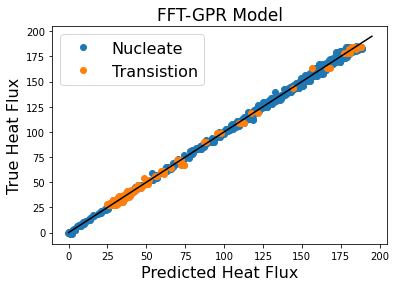

In [20]:
plt.plot(gpr.predict(fft_test)[time_test<chf_time],hf_test[time_test<chf_time],'o', label='Nucleate')
plt.plot(gpr.predict(fft_test)[time_test>=chf_time],hf_test[time_test>=chf_time],'o', label='Transistion')
plt.plot([0,195],[0,195], c='black')
plt.legend(fontsize=16)
plt.ylabel('True Heat Flux', fontsize=16)
plt.xlabel('Predicted Heat Flux', fontsize=16)
plt.title('FFT-GPR Model', fontsize=17)

In [21]:
fft_gpr_fn='./models_final/fft_gpr.pkl'
fft_gpr_model_pkl=open(fft_gpr_fn,'wb')
pickle.dump(gpr,fft_gpr_model_pkl)
fft_gpr_model_pkl.close()

## CNN Feature Transformation

In [22]:
# Create spectagrames
_,_,Sxx=signal.spectrogram(sound_train[0], int(1/dx_sound))
cnn_train=np.array(Sxx).reshape(1,Sxx.shape[0],Sxx.shape[1],1)
for i in range(len(sound_train)-1):
    _,_,Sxx=signal.spectrogram(sound_train[i+1],int(1/dx_sound))
    cnn_train=np.append(cnn_train, np.array(Sxx).reshape(1,Sxx.shape[0],Sxx.shape[1],1), axis=0)
    
_,_,Sxx=signal.spectrogram(sound_test[0], int(1/dx_sound))
cnn_test=np.array(Sxx).reshape(1,Sxx.shape[0],Sxx.shape[1],1)
for i in range(len(sound_test)-1):
    _,_,Sxx=signal.spectrogram(sound_test[i+1],int(1/dx_sound))
    cnn_test=np.append(cnn_test, np.array(Sxx).reshape(1,Sxx.shape[0],Sxx.shape[1],1), axis=0)

### MLP Model

In [23]:
filepath='./models_final/cnn-mlp-weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint1=ModelCheckpoint(filepath,monitor='val_loss',verbose=1,save_best_only=True,mode='min')
early_stop1=EarlyStopping(monitor='val_loss',patience=3,verbose=3)
callbacks_list1=[checkpoint1,early_stop1]

In [24]:
from tensorflow.keras import layers, models
fe=models.Sequential()
fe.add(layers.Conv2D(32,(3,3), activation='relu',input_shape=(cnn_train.shape[1],cnn_train.shape[2],1)))
fe.add(layers.MaxPooling2D((2,1)))
fe.add(layers.Conv2D(64, (2,2), activation='relu'))
fe.add(layers.MaxPooling2D((2,1)))
fe.add(layers.Conv2D(64,(3,3), activation='relu'))
fe.add(layers.MaxPooling2D(2,2))
fe.add(layers.Flatten())


x=fe.output
x=tf.keras.layers.Dense(100, activation='relu')(x)
x=tf.keras.layers.Dense(64, activation='relu')(x)
prediction_layer=tf.keras.layers.Dense(1)(x)

cnn_model=tf.keras.models.Model(inputs=fe.input, outputs=prediction_layer)

In [25]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')

In [26]:
spec_max=np.amax(cnn_train)

In [27]:
start=perf_counter()
cnn_model.fit(cnn_train/spec_max, hf_train, epochs=100, validation_split=0.1,callbacks=callbacks_list1)
stop=perf_counter()
print('Time: ', stop-start)
print('CNN-MLP-R2 Score:',sklearn.metrics.r2_score(hf_test,cnn_model.predict(cnn_test/spec_max)))
print('CNN-MLP-MAPE: ',mape(np.reshape(cnn_model.predict(cnn_test/spec_max),-1),hf_test))

Epoch 1/100
115/116 [============================>.] - ETA: 0s - loss: 3677.9302
Epoch 1: val_loss improved from inf to 827.66656, saving model to ./models_final\cnn-mlp-weights-improvement-01-827.67.hdf5
116/116 [==============================] - 7s 57ms/step - loss: 3667.7588 - val_loss: 827.6666
Epoch 2/100
115/116 [============================>.] - ETA: 0s - loss: 715.5369
Epoch 2: val_loss improved from 827.66656 to 366.78973, saving model to ./models_final\cnn-mlp-weights-improvement-02-366.79.hdf5
116/116 [==============================] - 7s 56ms/step - loss: 714.7804 - val_loss: 366.7897
Epoch 3/100
115/116 [============================>.] - ETA: 0s - loss: 237.8999
Epoch 3: val_loss improved from 366.78973 to 156.30931, saving model to ./models_final\cnn-mlp-weights-improvement-03-156.31.hdf5
116/116 [==============================] - 6s 56ms/step - loss: 238.0020 - val_loss: 156.3093
Epoch 4/100
115/116 [============================>.] - ETA: 0s - loss: 182.2161
Epoch 4: val

Time:  195.60142159999998
33/33 [==============================] - 0s 9ms/step
CNN-MLP-R2 Score: 0.9850872618349453
33/33 [==============================] - 0s 10ms/step

CNN-MLP-MAPE:  0.3439155543668364


33/33 [==============================] - 0s 9ms/step


Text(0.5, 1.0, 'CNN-MLP Model')

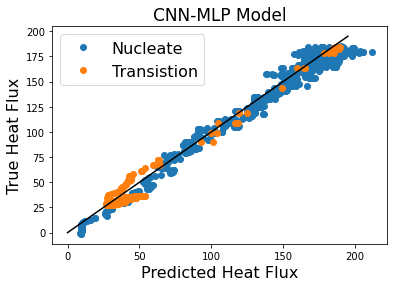

In [28]:
plt.plot(cnn_model.predict(cnn_test/spec_max)[time_test<chf_time],hf_test[time_test<chf_time],'o', label='Nucleate')
plt.plot(cnn_model.predict(cnn_test/spec_max)[time_test>=chf_time],hf_test[time_test>=chf_time],'o', label='Transistion')
plt.plot([0,195],[0,195], c='black')
plt.legend(fontsize=16)
plt.ylabel('True Heat Flux', fontsize=16)
plt.xlabel('Predicted Heat Flux', fontsize=16)
plt.title('CNN-MLP Model', fontsize=17)

### RFR Model

In [29]:
start=perf_counter()
cnn_train_features=fe.predict(cnn_train/spec_max)
stop=perf_counter()
print('Feature Transformation Time: ', stop-start)
cnn_test_features=fe.predict(cnn_test/spec_max)

129/129 [==============================] - 1s 10ms/step
Feature Transformation Time:  1.398546300000021
33/33 [==============================] - 0s 9ms/step


In [30]:
start=perf_counter()
cnn_rfr=RandomForestRegressor(max_depth=100,random_state=1)
cnn_rfr.fit(cnn_train_features,hf_train)
stop=perf_counter()
print('Time: ',stop-start)
print('CNN-RFR-R2 Score:',cnn_rfr.score(cnn_test_features,hf_test))
print('CNN-RFR-MAPE: ', mape(cnn_rfr.predict(cnn_test_features),hf_test))

Time:  742.1315548
CNN-RFR-R2 Score: 0.9982413383937287

CNN-RFR-MAPE:  0.039127533390021244


Text(0.5, 1.0, 'CNN-RFR Model')

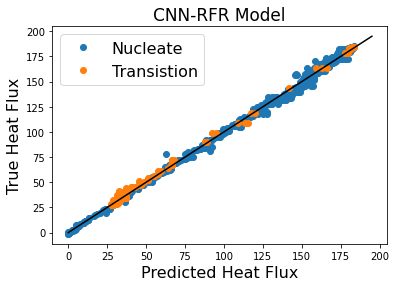

In [31]:
plt.plot(cnn_rfr.predict(cnn_test_features)[time_test<chf_time],hf_test[time_test<chf_time],'o', label='Nucleate')
plt.plot(cnn_rfr.predict(cnn_test_features)[time_test>=chf_time],hf_test[time_test>=chf_time],'o', label='Transistion')
plt.plot([0,195],[0,195], c='black')
plt.legend(fontsize=16)
plt.ylabel('True Heat Flux', fontsize=16)
plt.xlabel('Predicted Heat Flux', fontsize=16)
plt.title('CNN-RFR Model', fontsize=17)

In [32]:
cnn_rfr_fn='./models_final/cnn_rfr.pkl'
cnn_rfr_model_pkl=open(cnn_rfr_fn,'wb')
pickle.dump(cnn_rfr,cnn_rfr_model_pkl)
cnn_rfr_model_pkl.close()

### GPR Model

In [38]:
kernel=DotProduct(sigma_0_bounds=(0.0001,5000000)) + WhiteKernel(noise_level_bounds=(0.0001,5000000))
start=perf_counter()
cnn_gpr=GaussianProcessRegressor(kernel=kernel, random_state=0,)
cnn_gpr.fit(cnn_train_features,hf_train)
stop=perf_counter()
print('Time: ', stop-start)
print('CNN-GPR-R2 Score:',cnn_gpr.score(cnn_test_features,hf_test))
print('CNN-GPR-MAPE: ', mape(cnn_gpr.predict(cnn_test_features),hf_test))

Time:  14.20932730000004
CNN-GPR-R2 Score: 0.976915911814181

CNN-GPR-MAPE:  0.2931403281695389


Text(0.5, 1.0, 'CNN-GPR Model')

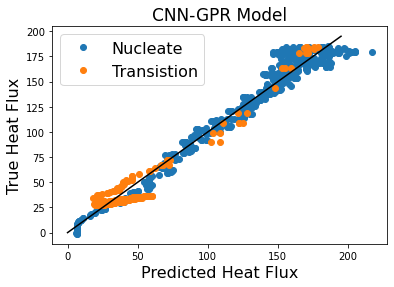

In [39]:
plt.plot(cnn_gpr.predict(cnn_test_features)[time_test<chf_time],hf_test[time_test<chf_time],'o', label='Nucleate')
plt.plot(cnn_gpr.predict(cnn_test_features)[time_test>=chf_time],hf_test[time_test>=chf_time],'o', label='Transistion')
plt.plot([0,195],[0,195], c='black')
plt.legend(fontsize=16)
plt.ylabel('True Heat Flux', fontsize=16)
plt.xlabel('Predicted Heat Flux', fontsize=16)
plt.title('CNN-GPR Model', fontsize=17)

In [40]:
cnn_gpr_fn='./models_final/cnn_gpr.pkl'
cnn_gpr_model_pkl=open(cnn_gpr_fn,'wb')
pickle.dump(cnn_gpr,cnn_gpr_model_pkl)
cnn_gpr_model_pkl.close()